In [1]:
import os

import tifffile
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, Dataset
from einops import rearrange

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
from dino_extended.data.utils import listfiles
from dino_extended.data.multiplex import TileTransform
from dino_extended.models.dino import Dino
from dino_extended.models.vit import ViT, Recorder, Extractor

In [5]:
fps = sorted(listfiles('/data/spatial_transcriptomics/highres_images/breast', regex=r'HT206B1.*.tif'))
fps

['/data/spatial_transcriptomics/highres_images/breast/20201103_ST_HT206B1-S1Fc1U2.tif',
 '/data/spatial_transcriptomics/highres_images/breast/20201103_ST_HT206B1-S1Fc1U3.tif',
 '/data/spatial_transcriptomics/highres_images/breast/20201103_ST_HT206B1-S1Fc1U4.tif',
 '/data/spatial_transcriptomics/highres_images/breast/20201103_ST_HT206B1-S1Fc1U5.tif']

In [6]:
def preprocess_he(img, scale=None):
    if isinstance(img, str):
        img = tifffile.imread(img)

    img = torch.tensor(img, dtype=torch.float32)
    img = rearrange(img, 'h w c -> c h w')
    
    img -= img.min()
    img /= img.max()

    if scale is not None:
        size = int(img.shape[-2] * scale), int(img.shape[-1] * scale)
        img = TF.resize(img, size)

    return img

In [7]:
class TileDataset(Dataset):
    """Registration Dataset"""
    def __init__(self, hes, size=(256, 256), scale=None, transform=None, length=2**13):
        self.length = length
        self.hes = [preprocess_he(he, scale=scale) for he in hes]

        self.transform = transform if transform is not None else TileTransform(size=size)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        i = (idx + 1) % len(self.hes)
        return self.transform(self.hes[i])

In [21]:
size = (256, 256)
scale = .5
ds = TileDataset(fps, size=size, scale=scale)

In [24]:
tile = ds[0]
tile.shape

torch.Size([3, 256, 256])

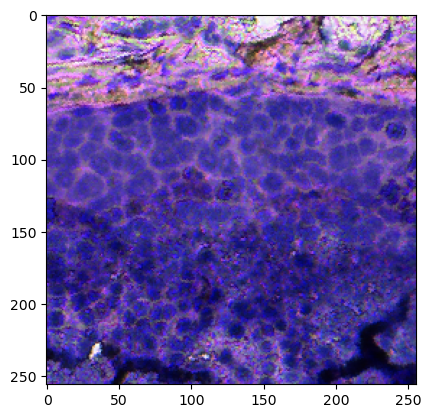

In [25]:
plt.imshow(rearrange(tile.numpy(), 'c h w -> h w c'))

In [10]:
dl = DataLoader(ds, batch_size=128, shuffle=True, num_workers=40)

In [11]:
b = next(iter(dl))
b.shape

torch.Size([128, 3, 256, 256])

In [12]:
model = ViT(
    image_size = size[0],
    patch_size = 32,
    num_classes = 1000,
    dim = 1024,
    depth = 6,
    heads = 8,
    mlp_dim = 2048
)

In [13]:
learner = Dino(
    model,
    image_size = size[0],
    hidden_layer = 'to_latent',        # hidden layer name or index, from which to extract the embedding
    projection_hidden_size = 256,      # projector network hidden dimension
    projection_layers = 4,             # number of layers in projection network
    num_classes_K = 65336,             # output logits dimensions (referenced as K in paper)
    student_temp = 0.9,                # student temperature
    teacher_temp = 0.04,               # teacher temperature, needs to be annealed from 0.04 to 0.07 over 30 epochs
    local_upper_crop_scale = 0.4,      # upper bound for local crop - 0.4 was recommended in the paper 
    global_lower_crop_scale = 0.5,     # lower bound for global crop - 0.5 was recommended in the paper
    moving_average_decay = 0.9,        # moving average of encoder - paper showed anywhere from 0.9 to 0.999 was ok
    center_moving_average_decay = 0.9, # moving average of teacher centers - paper showed anywhere from 0.9 to 0.999 was ok
)

In [14]:
# multi_learner = torch.nn.DataParallel(learner, device_ids=[0,1,2])
# multi_learner = multi_learner.to(0)

In [15]:
# input        = input.to(0)
# parallel_net = parellel_net.to(0)

In [16]:
learner = learner.to(0)

In [17]:
opt = torch.optim.Adam(learner.parameters(), lr = 3e-4)

In [18]:
for b in dl:
    b = b.to(0)
    loss = learner(b)
    opt.zero_grad()
#     loss.sum().backward()
    loss.backward()
    opt.step()
    learner.update_moving_average() # update moving average of teacher encoder and teacher centers
    print(loss)

tensor(11.0208, device='cuda:0', grad_fn=<DivBackward0>)
tensor(11.0310, device='cuda:0', grad_fn=<DivBackward0>)
tensor(11.0283, device='cuda:0', grad_fn=<DivBackward0>)
tensor(11.0300, device='cuda:0', grad_fn=<DivBackward0>)
tensor(11.0317, device='cuda:0', grad_fn=<DivBackward0>)
tensor(11.0333, device='cuda:0', grad_fn=<DivBackward0>)
tensor(11.0345, device='cuda:0', grad_fn=<DivBackward0>)
tensor(11.0352, device='cuda:0', grad_fn=<DivBackward0>)
tensor(11.0358, device='cuda:0', grad_fn=<DivBackward0>)


KeyboardInterrupt: 

In [ ]:
# preds, attns = v(img)

# # there is one extra patch due to the CLS token

# attns # (1, 6, 16, 65, 65) - (batch x layers x heads x patch x patch)

In [40]:
v = Recorder(model)

In [42]:
preds, attns = v(b)

In [44]:
attns.shape

torch.Size([4, 6, 8, 65, 65])

In [ ]:
# v = v.eject()  # wrapper is discarded and original ViT instance is returned

In [45]:
b.shape

torch.Size([4, 3, 256, 256])

In [47]:
v = Extractor(model)

In [48]:
logits, embeddings = v(b)

In [49]:
logits.shape, embeddings.shape

(torch.Size([4, 1000]), torch.Size([4, 65, 1024]))